This notebook aims to explore the composition of the top 5 European football/soccer leagues (English, French, German, Italian and Spanish) by comparing their employment of foreign players and the amount of playing time that is actually given to them. The data for this notebook was sourced completely from https://www.transfermarkt.co.uk/.

**Import relevant packages**

In [187]:
%matplotlib inline
import json
import csv
from pprint import pprint
import pandas as pd
import seaborn as sns
import math
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import os
from math import log as ln

**Some methods that will be used everywhere **

In [188]:
'''
Source code from https://github.com/oliviaguest/gini
'''
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

'''
Source code from: https://gist.github.com/audy/783125
'''
def sdi(data):        
    N = sum(data.values())

    def p(n, N):
        """ Relative abundance """
        if n is  0:
            return 0
        else:
            return (float(n)/N) * ln(float(n)/N)
    
    return -sum(p(n, N) for n in data.values() if n is not 0)

I decided to use the shannon diversity index (https://en.wikipedia.org/wiki/Diversity_index#Shannon_index) to quantify the diversity of teams. The function **sdi** takes a dictionary as its parameter. In this case, the dictionary for each team consists of the name of the country as the key and the number of players from that country in the team as the value. 

In [189]:
#All the soccer playing nations in the dataset
L_countries = {}
nations_path = '../data/Nations.txt'
with open(nations_path) as nations_file:
	for nation in nations_file:
		L_countries[nation.replace('\n','')] = 0
        
#Common methods to be used across multiple scripts

def minutes_parser(minutes_string):
    if minutes_string == '-':
        return 0
    return int(minutes_string.replace('\'','').replace('.',''))

def csv_writer(params, values_lists, path):
    with open(path, "w") as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
              
        writer.writerow(params)
        
        for line in values_lists:
            writer.writerow(line)
            
def csv_dict_reader(file_obj):
    reader = csv.DictReader(file_obj, delimiter=',')
    for line in reader:
        print(line["Name"])
        #print(line["Matches"])

def csv_reader(file_obj):
    reader = csv.reader(file_obj)
    for row in reader:
        print(" ".join(row))

#the heatmap to plot from dataframe 'df'
def plot(df):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(8,8))
    sns.set(font_scale=0.8)
    sns.heatmap(corr, cmap="YlGnBu", annot=True, annot_kws={"size": 13})#, ax = ax)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()

def plot_time_series(df, title, y_top=100):
    #plot graph
    ax = df.plot(figsize=(12,7.5),marker='o')
       
    #set title
    plt.title(title, fontsize=13)
    
    #set ticks roatation
    plt.xticks(rotation=90)
    ax.set_ylabel('Percentages')
       
    ax.set_ylim(top=y_top)
    ax.set_ylim(bottom=0)

    plt.show()

## 1. Comparing percentage of playing time given to foreign players in each league

In [190]:
def get_league_comparison_df(option = 0):
	years = [str(year) for year in range(1995, 2017)]
	countries = ['England', 'France', 'Germany', 'Italy', 'Spain']
	L_all_data = []

	for country in countries:
		data_file = data_file = '../data/Leistungsdaten/' + str(country) + '/2016.json'

		L_local = []
		L_foreign = []

		L_local_minutes = []
		L_foreign_minutes = []

		L_local_apps = []
		L_foreign_apps = []

		with open(data_file) as datafile:
			data = json.load(datafile)
			for year in years:
				local = 0
				foreign = 0
				local_minutes = 0
				foreign_minutes = 0
				local_apps = 0
				foreign_apps = 0

				#data for a particular year
				league_year_data = data[year]
				#go trhough each team in the year
				for team in league_year_data:
					year_data = data[year][team]

					for key in year_data:
						player = year_data[key]
						player_country = player['nationality']
						if(player_country == country):
							local += 1
							local_minutes += minutes_parser(player['minutes'])
							local_apps += player['appearances']
						else:
							foreign += 1
							foreign_minutes += minutes_parser(player['minutes'])
							foreign_apps += player['appearances']

				total = local + foreign
				L_local.append((local/total)*100)
				L_foreign.append((foreign/total)*100)

				total = local_apps + foreign_apps
				L_local_apps.append((local_apps/total) * 100)
				L_foreign_apps.append((foreign_apps/total) * 100)

				total = local_minutes + foreign_minutes
				L_local_minutes.append((local_minutes/total)*100)
				L_foreign_minutes.append((foreign_minutes/total)*100)
            
		if option == 0:
			L_all_data.append(L_foreign_minutes)
		elif option == 1:
			L_all_data.append(L_foreign)
		elif option == 2:
			L_all_data.append(L_foreign_apps)


	df = pd.DataFrame({'England': L_all_data[0],
						'France': L_all_data[1],
						'Germany': L_all_data[2],
						'Italy' : L_all_data[3],
						'Spain' : L_all_data[4],
						'Year': years			})
	df = df.set_index('Year')
	return df

        England     France    Germany      Italy      Spain
Year                                                       
1995  36.391551  20.076871  23.545465  19.118457  21.096770
1996  44.389853  27.630522  28.983765  25.135736  35.178378
1997  48.640584  26.143216  36.123795  27.975180  42.478662
1998  52.518440  28.061479  41.135187  31.741860  43.113172
1999  55.197259  29.639085  42.594335  32.783777  40.834220
2000  55.140512  33.377798  49.620621  35.506366  37.578903
2001  58.561312  38.344064  52.267888  32.203117  34.787820
2002  61.951640  41.634428  58.677507  31.831739  34.139652
2003  63.276169  43.473815  57.181072  32.183689  38.339908
2004  62.238905  48.217958  54.699211  28.895867  33.624242
2005  62.235778  48.576804  54.168397  30.038399  36.577624
2006  61.291384  46.571375  55.300211  26.364379  39.117465
2007  65.018765  44.526110  56.506061  32.578788  39.653607
2008  63.191627  46.055635  58.543315  38.102057  36.898817
2009  65.831715  49.432226  57.502628  4

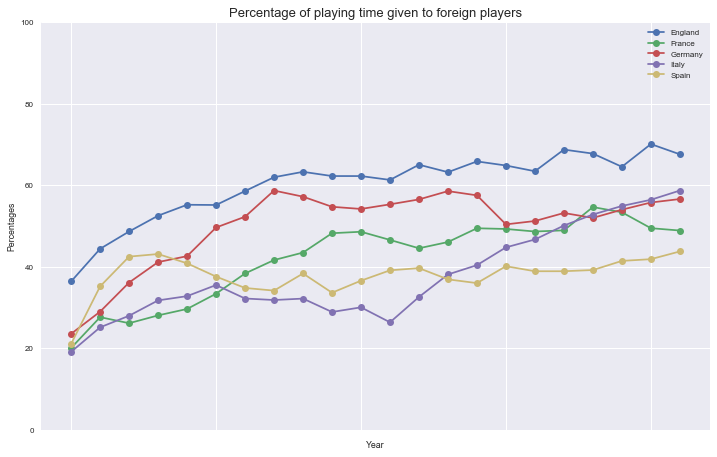

In [191]:
df = get_league_comparison_df()
pprint(df)
plot_time_series(df, 'Percentage of playing time given to foreign players',100)

The English league has been the most 'generous' in terms of giving playing time to foreign players (the percentage has consistently been above 60 in last 13 years). The Italian league has seen a consistent increase since 2006. 

These stats aren't useful without knowing the percentage of players belonging to a certain nationality that were present in the leagues. For instance, the fact that the English league gives 100% percentage of playing time to foreign players won't be as significant if the percentage of English players in all the leagues was 0. However, it *will* be more impressive if the percentage of English players was say, 50.

## 2. Comparing percentage of players of certain nationalities in the top 5 soccer leagues

In [192]:
def get_nationalities_df():
	years = [str(year) for year in range(1995, 2017)]
	countries = ['England', 'France', 'Germany', 'Italy', 'Spain']

	final_data = []

	for country in countries:
		final_data.append([])
		for year in years:
			final_data[-1].append(0)

	for year in years:
		total = 0

		for country in countries:
			data_file = '../data/Leistungsdaten/' + str(country) + '/2016.json'

			with open(data_file) as datafile:
				data = json.load(datafile)

				#data for a particular year
				league_year_data = data[year]
				#go trhough each team in the year
				for team in league_year_data:
					year_data = data[year][team]
					#each player
					for key in year_data:
						player = year_data[key]
						player_country = player['nationality']
						if player_country in countries:
							final_data[countries.index(player_country)][int(year) - 1995] += 1
						total += 1

		for country in countries:
			final_data[countries.index(country)][int(year) - 1995] /= total
			final_data[countries.index(country)][int(year) - 1995] *= 100

	L_all_data = final_data

	df = pd.DataFrame({'English': L_all_data[0],
						'French': L_all_data[1],
						'German': L_all_data[2],
						'Italian' : L_all_data[3],
						'Spanish' : L_all_data[4],
						'Year': years			})
	df = df.set_index('Year')
	return df

        English     French     German    Italian    Spanish
Year                                                       
1995  13.954358  16.647961  14.141414  15.488215  16.049383
1996  12.680014  15.033368  14.014752  15.700738  15.033368
1997  12.052796  14.379993  12.400139  15.977770  12.678013
1998  11.282579  15.157750  12.174211  15.226337  11.522634
1999  10.896130  14.528174  11.812627  14.562118  12.457570
2000   9.772727  13.084416  11.233766  15.876623  12.012987
2001   8.794137  14.890073  10.426382  14.223851  12.491672
2002   8.629776  14.657444   9.617918  13.735178  14.196311
2003   8.314461  13.717244   9.576189  14.234875  14.137819
2004   7.960039  12.665163   9.216887  16.016758  15.178859
2005   7.492795  12.872238  10.246558  16.266411  13.320525
2006   8.333333  11.842105   9.461153  16.384712  13.063910
2007   7.997539  11.934789   9.412488  14.241772  12.796063
2008   8.478261  12.267081   8.664596  13.913043  13.012422
2009   8.646392  11.598092   8.944544  1

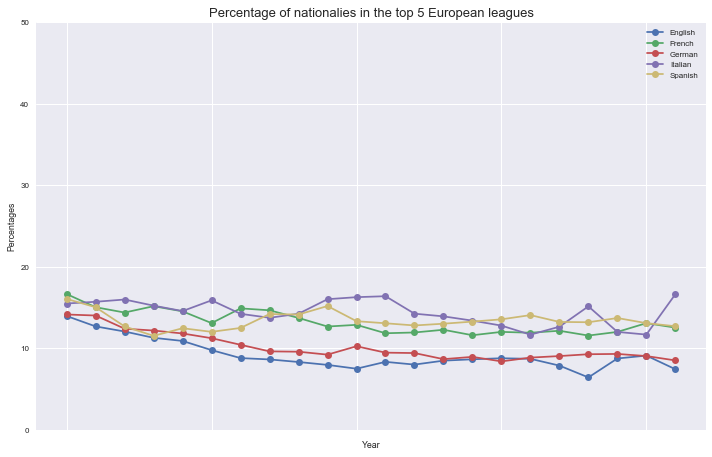

In [193]:
df = get_nationalities_df()
pprint(df)
plot_time_series(df, 'Percentage of nationalies in the top 5 European leagues',50)

The percentage of English players in these leagues has dropped below 10 since 2000; explaining why the English league has given a larger percentage of playing time to foreign players. This plot mirrors the results seen in the plot depicting the percentage of playing time given to foreign players.

## 3. Where do the players go? Seeing which countries players of certain nationalities prefer to play in.

It's understandable that players will prefer staying in their own country and participate in that domestic league. However, powerful clubs like Bayern Munich, Real Madrid and FC Barcelona have the resources to attract the best foreign talent. It would be interesting to see how players of certain nationalities are distributed in these 5 leagues. Do the Italians prefer playing in the domestic league more than the Germans?

In [194]:
def get_nationality_distribution_df(target_country):
	countries = ['England', 'France', 'Germany', 'Italy', 'Spain']
	years = [str(year) for year in range(1995, 2017)]

	values = {}

	for country in countries:
		country_info = {}
		data_file = '../data/Leistungsdaten/' + str(country) + '/2016.json'
		with open(data_file) as datafile:
			data = json.load(datafile)

			for year in years:
				count = 0
				year_data = data[year]

				for key in year_data:
					players = year_data[key]
					for player in players:
						player_info = players[player]
						player_country = player_info['nationality']
						if(player_country == target_country):
							count += 1

				country_info[year] = count
		values[country] = country_info

	for year in years:
		year_sum = 0
		for country in countries:
			year_sum += values[country][year]
		for country in countries:
			values[country][year] /= year_sum
			values[country][year] *= 100
	
	df = pd.DataFrame({'England': list(values['England'].values()),
						'France': list(values['France'].values()),
						'Germany': list(values['Germany'].values()),
						'Italy' : list(values['Italy'].values()),
						'Spain' : list(values['Spain'].values()),
						'Year': years			})
	df = df.set_index('Year')
	return df

         England    France   Germany     Italy     Spain
Year                                                    
1995   99.463807  0.268097  0.000000  0.268097  0.000000
1996   98.337950  0.831025  0.277008  0.554017  0.000000
1997   98.847262  0.576369  0.000000  0.576369  0.000000
1998   99.696049  0.000000  0.000000  0.303951  0.000000
1999   99.376947  0.000000  0.000000  0.000000  0.623053
2000   98.671096  0.000000  0.332226  0.000000  0.996678
2001   98.863636  0.000000  0.378788  0.000000  0.757576
2002   98.854962  0.000000  0.381679  0.000000  0.763359
2003   98.832685  0.000000  0.389105  0.389105  0.389105
2004   98.380567  0.000000  0.404858  0.000000  1.214575
2005   98.717949  0.000000  0.427350  0.000000  0.854701
2006   98.872180  0.000000  0.375940  0.000000  0.751880
2007  100.000000  0.000000  0.000000  0.000000  0.000000
2008   99.267399  0.366300  0.000000  0.366300  0.000000
2009   99.310345  0.000000  0.000000  0.344828  0.344828
2010  100.000000  0.000000  0.0

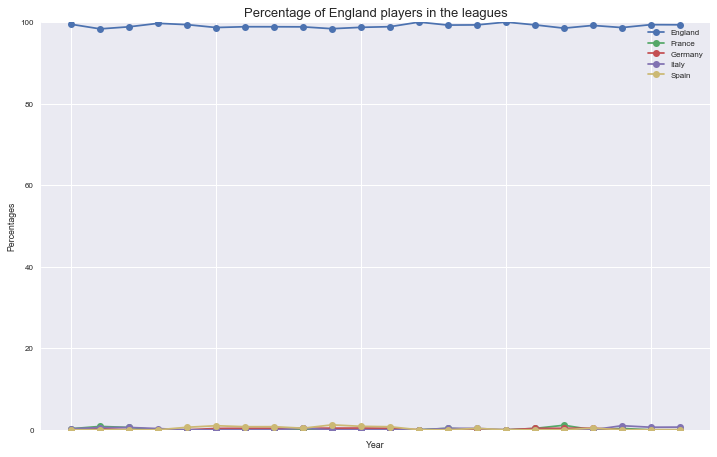

In [195]:
target_country = 'England'
df = get_nationality_distribution_df(target_country)
pprint(df)
plot_time_series(df, 'Percentage of ' + target_country + ' players in the leagues')

Not only is the percentage of English players lower than the other nationalities, but, English players are **heavily** biased towards staying in their own domestic league. From 1995 to 2017, at least 98% of English players in these leagues choose to play in their domestic league (English Premier League). In 2007 and 2010, *all* the English players played in the EPL!

        England     France   Germany     Italy     Spain
Year                                                    
1995   0.674157  97.752809  0.224719  1.123596  0.224719
1996   2.102804  91.588785  0.467290  3.037383  2.803738
1997   4.830918  86.956522  0.966184  4.347826  2.898551
1998   5.882353  86.651584  0.678733  4.977376  1.809955
1999   5.373832  86.682243  1.168224  4.672897  2.102804
2000   6.947891  85.607940  1.488834  4.714640  1.240695
2001   9.172260  81.879195  1.565996  5.369128  2.013423
2002   9.887640  84.044944  0.674157  3.595506  1.797753
2003  10.613208  82.547170  1.886792  3.301887  1.650943
2004   9.923664  82.442748  2.035623  3.053435  2.544529
2005   8.955224  83.084577  1.741294  3.233831  2.985075
2006   7.671958  82.804233  0.793651  3.703704  5.026455
2007   7.731959  81.185567  3.092784  3.865979  4.123711
2008   7.594937  82.531646  2.784810  3.544304  3.544304
2009   8.226221  82.776350  2.056555  3.084833  3.856041
2010   6.913580  83.950617  2.4

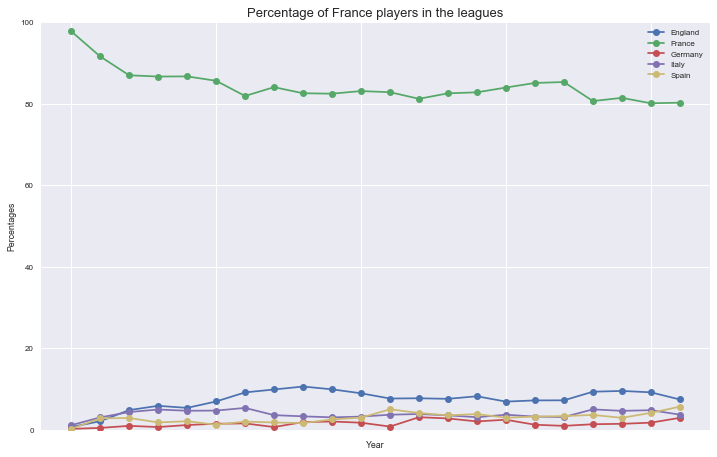

In [196]:
target_country = 'France'
df = get_nationality_distribution_df(target_country)
pprint(df)
plot_time_series(df, 'Percentage of ' + target_country + ' players in the leagues')

France is a much more interesting case than England with more players opting to leave their home country and playing outside. The French League (Ligue 1) has been considered to be weaker than the other leagues primarily due to disparity between top teams with a lot of money and power (PSG and AS Monaco for instance) and bottom teams. The bottom order teams are not able to give a good competition to the top teams; making the league relatively predictable and boring. The EPL, for instance is more prone to shocking results.

Besides this, the Ligue 1 has been considered a 'feeder' league, with many other top teams taking away their players. Alexandre Lacazette, Anthony Martial, Corentin Tolisso and Karim Benzema are just some of these players (all French). This has changed in recent times with the wealthy clubs spending more (a lot!) to bring in elite international players (like Neymar Jr.). However, that doesn't translate to a higher domestic player retention rate.

Ineterestingly, the dips and crests in the percentage of French players in France mirrors the crests and dips in the percentage of French players in England; potentially indicating that many of these players went to England.

       England    France    Germany     Italy     Spain
Year                                                   
1995  0.793651  0.000000  98.941799  0.264550  0.000000
1996  0.250627  0.250627  98.245614  0.501253  0.751880
1997  1.400560  0.840336  96.078431  1.400560  0.280112
1998  1.690141  0.845070  95.492958  1.690141  0.281690
1999  2.298851  0.000000  96.264368  0.862069  0.574713
2000  3.468208  0.000000  95.664740  0.289017  0.578035
2001  2.555911  0.319489  96.805112  0.319489  0.000000
2002  2.739726  0.000000  95.890411  1.027397  0.342466
2003  3.378378  0.000000  95.608108  1.013514  0.000000
2004  1.748252  0.000000  98.251748  0.000000  0.000000
2005  1.562500  0.000000  98.125000  0.312500  0.000000
2006  2.317881  0.000000  97.019868  0.000000  0.662252
2007  2.287582  0.000000  96.405229  0.000000  1.307190
2008  1.792115  0.358423  97.132616  0.000000  0.716846
2009  1.666667  0.333333  96.666667  1.000000  0.333333
2010  1.766784  0.000000  97.526502  0.000000  0

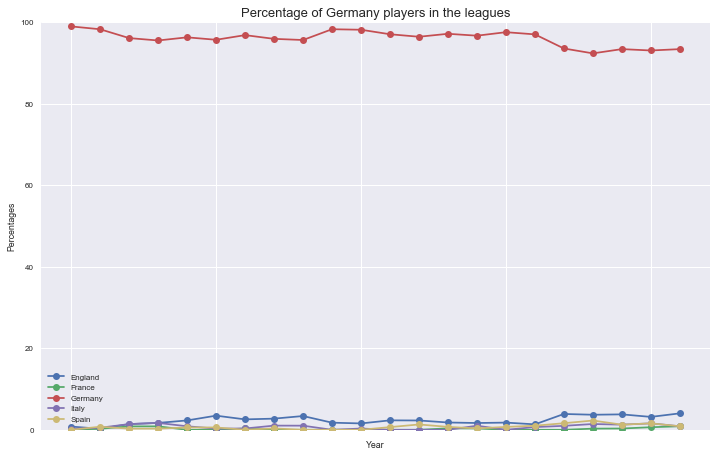

In [197]:
target_country = 'Germany'
df = get_nationality_distribution_df(target_country)
pprint(df)
plot_time_series(df, 'Percentage of ' + target_country + ' players in the leagues')

Nothing too interesting here. Not too many German players go to France. They mostly prefer playing in the Bundesliga.

       England    France   Germany      Italy     Spain
Year                                                   
1995  0.241546  0.000000  0.241546  99.516908  0.000000
1996  1.565996  0.671141  0.447427  96.868009  0.447427
1997  3.260870  0.869565  0.434783  94.565217  0.869565
1998  4.279279  1.126126  0.000000  92.792793  1.801802
1999  3.030303  0.932401  0.466200  94.871795  0.699301
2000  2.453988  0.408998  0.817996  95.705521  0.613497
2001  3.512881  0.936768  0.702576  94.145199  0.702576
2002  1.918465  0.479616  0.479616  96.163070  0.959233
2003  2.045455  0.681818  0.454545  96.136364  0.681818
2004  1.207243  0.402414  0.201207  96.177062  2.012072
2005  1.377953  0.787402  0.000000  95.472441  2.362205
2006  1.720841  0.382409  0.191205  95.984704  1.720841
2007  0.863931  0.431965  0.431965  95.464363  2.807775
2008  1.562500  0.669643  1.339286  95.312500  1.116071
2009  2.004454  0.445434  1.113586  95.545657  0.890869
2010  1.856148  0.000000  1.160093  95.359629  1

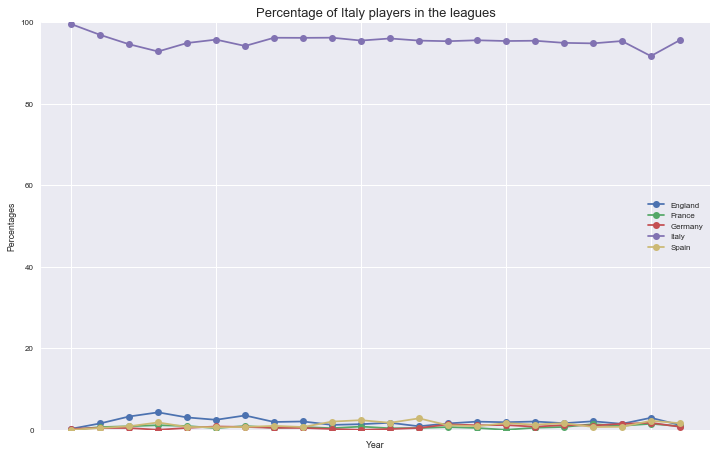

In [198]:
target_country = 'Italy'
df = get_nationality_distribution_df(target_country)
pprint(df)
plot_time_series(df, 'Percentage of ' + target_country + ' players in the leagues')

In the graph showing the percentage of players by their nationality, it was observed that Italians make up a large percentage of the total players in the league. This made me believe that Italian players would be more 'distributed' because there's a higher probability that they will shift to different countries because of an abundance of players in their own league. However, that is not true as a large percentage (at least 92% from 1995-2016) of players chose to play in the Serie A

       England    France   Germany     Italy       Spain
Year                                                    
1995  0.000000  0.000000  0.000000  0.000000  100.000000
1996  0.000000  0.233645  0.000000  0.000000   99.766355
1997  0.000000  0.273973  0.000000  0.821918   98.904110
1998  0.297619  0.892857  0.000000  0.892857   97.916667
1999  0.544959  0.272480  0.272480  0.817439   98.092643
2000  0.540541  0.810811  0.540541  1.081081   97.027027
2001  0.800000  1.066667  0.000000  2.933333   95.200000
2002  1.392111  0.232019  0.928074  0.696056   96.751740
2003  1.144165  0.915332  0.915332  0.457666   96.567506
2004  3.184713  0.636943  0.424628  0.636943   95.116773
2005  4.086538  0.480769  0.480769  0.000000   94.951923
2006  3.117506  0.239808  0.000000  0.000000   96.642686
2007  3.846154  0.240385  0.000000  0.240385   95.673077
2008  3.818616  0.000000  0.000000  0.238663   95.942721
2009  3.370787  0.224719  0.000000  0.898876   95.505618
2010  5.032823  0.656455  0.656

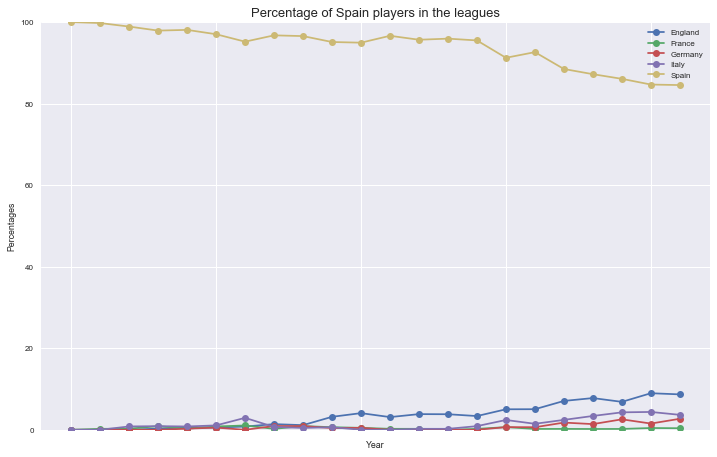

In [199]:
target_country = 'Spain'
df = get_nationality_distribution_df(target_country)
pprint(df)
plot_time_series(df, 'Percentage of ' + target_country + ' players in the leagues')

Spain is a much more interesting case; not only because of the graph but also due to the fact that Spanish players make up a larger percentage of the total players in these leagues. This means that there is a higher probability that Spanish players will leave their country to play in other leagues. Clearly, more Spanish players leave their home than the other players mentioned above (not as much as French players). The English league gets the most Spanish players; followed by the Italian league. 

### 3.1. What all this shows

While it is expected, and demonstrated that players will have an affinity towards their own domestic leagues, the case of French players is interesting because they are more likely to play in a foreign league than the English, German, Italian and Spanish players. As mentioned above, this could be because the Ligue 1 (French league) is typically dominated by 2-3 teams and doesn't pose enough of a challenge for more talented players. 

The Italian league (Serie A) came as a surprise to me because, despite the large number of Italian players present in these leagues, the Serie A is a big attraction for these Italian players. My belief was that due to the large numbers, player would prefer moving to different leagues for a better shot at getting more match time. However, as it turns it out, this is not the case despite the fact that teams in the Serie A have been giving more than 50% playing time to foreign players in the last 5 years. This, despite the fact that the percentage of foreign players in the league has been roughly less than 50 in the past few years (as shown in the plot below). This means that a lot of the Italian players are probably kept as subsitutes and brought on later in the game to replace the international players.

Due to the smaller fraction of English players, the teams of the English Premier League have to rely more on international players in order to fill their squads.  

        England     France    Germany      Italy      Spain
Year                                                       
1995  38.166667  21.480144  24.748491  14.699793  20.408163
1996  41.515651  26.315789  27.941176  19.516729  31.789137
1997  49.185185  31.297710  34.416826  25.129088  37.326389
1998  50.971599  30.615942  39.464286  30.169492  39.633028
1999  52.670623  31.423290  39.856373  32.053422  37.391304
2000  56.387665  35.992579  44.276094  33.333333  36.347518
2001  58.173077  39.603960  47.577855  37.285491  35.443038
2002  59.782609  41.653666  50.963222  32.148900  29.202037
2003  61.162080  44.444444  50.176056  32.428115  31.158238
2004  61.671924  47.317073  50.440917  28.443114  27.625202
2005  62.560778  48.297214  46.232877  28.989751  33.389545
2006  61.828737  48.939641  48.415493  28.995757  34.471545
2007  63.737796  49.519231  50.996678  35.942029  35.598706
2008  61.063218  48.742138  54.377104  37.664234  33.990148
2009  61.342282  50.537634  52.614379  3

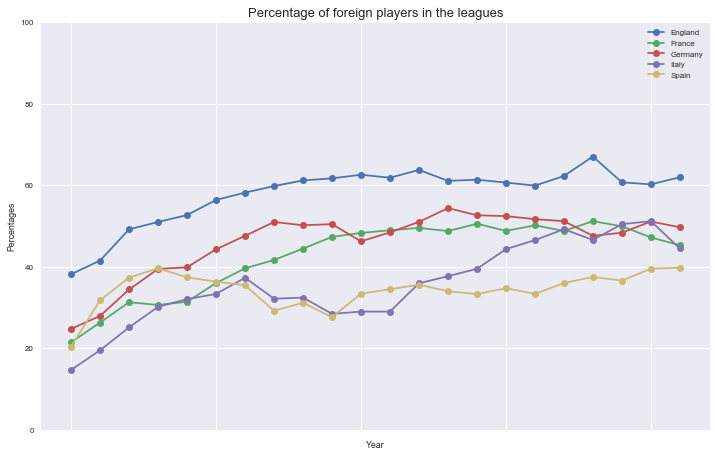

In [200]:
df = get_league_comparison_df(1)
pprint(df)
plot_time_series(df, 'Percentage of foreign players in the leagues',100)

## 4. Correlation between diversity, foreign playing time percentage, winning etc.

It will be interesting to see the correlation between diversity (quantified by the Shannon diversity index mentioned previously), percentage of playing time given to international players and winning. 

Some points worth noting before the correlations are calculated:

* The number of mathches played is not the same for all leagues. The German league has 34 matches whereas the Spanish league has 38 matches in a season. This will lead to fluctuations in the number of matches won, total points scored, etc. 
* To combat the issue mentioned above, the values for total wins, losses, goals for, goals against and points in a season were divided by the total matches played. Points per match, for instance is a much better metric because all these leagues have 3 points for win, 1 for draw and 0 for loss. This solves the problem where teams in a 38 match league will (with a high probability) have more points than teams in a 34 match league.
* For each league, the data from 22 seasons (1995-2017) was used. When the correlation matrix was calculated for each one of these leagues, the correlation values observed weren't 'high' enough to be deemed statistically significant for the amount of data used. So, I have omitted those matrices and calculated the correlation matrix for all leagues combined (for a total of 110 data points; 5 leagues and 22 seasons per league). The results are shown below.

### 4.1 Correlation across all leagues

In [201]:
def get_team_percentage(country, data, year, team):
	age = 0
	local = 0
	foreign = 0
	local_minutes = 0
	foreign_minutes = 0
	local_apps = 0
	foreign_apps = 0

	for nation in L_countries:
			L_countries[nation] = 0 

	
	year_data = data[year][team]

	for key in year_data:
		player = year_data[key]
		player_country = player['nationality']
		if(player_country == country):
			local += 1
			local_minutes += minutes_parser(player['minutes'])
			local_apps += player['appearances']
		else:
			foreign += 1
			foreign_minutes += minutes_parser(player['minutes'])
			foreign_apps += player['appearances']
		age += (player['age'] * minutes_parser(player['minutes']))
		#increase the country count
		if player_country != 'N/A':
			L_countries[player_country] = L_countries[player_country] + player['appearances']
	

	#gini_value = gini(np.asarray(list(L_countries.values()), dtype=np.float))
	diversity = sdi(L_countries)
	average_age = age/(local + foreign)
	total = local_minutes + foreign_minutes
	return [(foreign_minutes/total)*100, average_age, diversity]

def get_combined_correlations():
	years = [year for year in range(1995, 2017)]
	params = ['Won', 'Lost', 'Draw', 'GF', 'GA',  'PPM', 'Foreign playing minutes %', 'Average age', 'diversity']
	countries = ['England', 'France', 'Germany', 'Italy', 'Spain']
	rows = []

	for country in countries:
		data_file = '../data/Leistungsdaten/' + str(country) + '/2016.json'

		for year in years:
			path = '../data/Standings/' + country + '/' + str(year) + '.csv'

			with open(path, "r") as file_obj:
				reader = csv.DictReader(file_obj, delimiter=',')

				with open(data_file) as datafile:
					data = json.load(datafile)
					for line in reader:

						#new row data for each team
						row = []
						team_name = line['Name']
						# pprint(team_name + ':  ' + str(get_team_percentage(data, '2001', team_name)))
						# pprint(line)
						won_matches = int(line['Won'])
						lost_matches = int(line['Lost'])
						draw_matches = int(line['Draw'])
						total_matches = won_matches + lost_matches + draw_matches
						row.append(won_matches/total_matches)
						row.append(lost_matches/total_matches)
						row.append(draw_matches/total_matches)
						row.append(int(line['GF']))
						row.append(int(line['GA']))
						#row.append(int(line['Points']))
						row.append(float(line['PPM']))
						vals = get_team_percentage(country, data, str(year), team_name)

						row.append(vals[0])
						row.append(vals[1])
						row.append(vals[2])

						rows.append(row)
	csv_writer(params, rows, 'out.csv')

	df = pd.read_csv('out.csv')
	os.remove('out.csv')   
	return df 

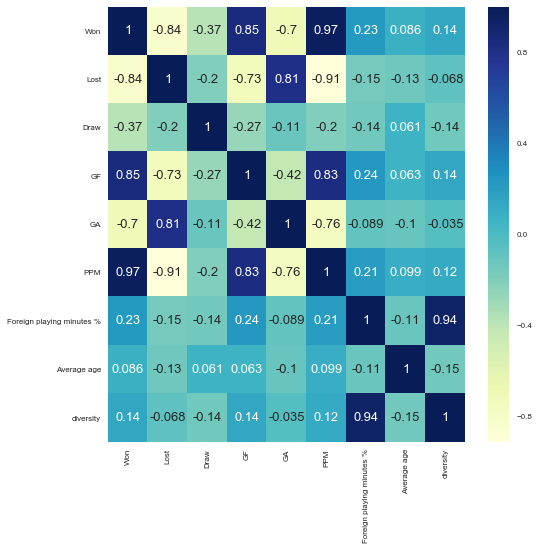

In [202]:
df = get_combined_correlations()
plot(df)

Using the table provided in https://www.texasgateway.org/resource/126-outliers, for 110 data points, a correlation value greater than 0.19 and less than -0.19 will be considered statistically significant with a siginificance level of 0.05.

The correlation value of 0.23 between the percentage of playing time given to foreign players and the percentage of matches won in a season suggests a statistically significant linear relation. Figuring out if there's a causal relationship between these two parameters would require us to take into account the quality of players as well. The mere prescence of a foreign player is not as important as their quality. This could also mean that teams are more picky when investing in foreign players and giving them playing time; leading to that correlation value.

The correlation values of -0.15 between average age and diversity; although not statistically significant given our siginificance level, seems interesting and worth exploring given data from more seasons. It might suggest that more teams tend to get younger foreign players.

## 5. Interesting cases

I plotted the percentage of foreign players, foreign appearances (matches played irrespective of if the player came on as a substitute) and foreign playing time for teams. Some interesting cases are presented below.

In [203]:
def get_team_percentages_df(country, team):
	data_file = '../data/Leistungsdaten/' + str(country) + '/2016.json'
	years = [str(year) for year in range(1995, 2017)]

	L_local = []
	L_foreign = []

	L_local_minutes = []
	L_foreign_minutes = []

	L_local_apps = []
	L_foreign_apps = []



	years_copy = [str(year) for year in range(1995, 2017)]

	with open(data_file) as datafile:
		data = json.load(datafile)
		for year in years:
			local = 0
			foreign = 0
			local_minutes = 0
			foreign_minutes = 0
			local_apps = 0
			foreign_apps = 0
			L_countries = {}
			#data for a particular year
			try:
				year_data = data[year][team]

				for key in year_data:
					player = year_data[key]
					player_country = player['nationality']
					if(player_country == country):
						local += 1
						local_minutes += minutes_parser(player['minutes'])
						local_apps += player['appearances']
					else:
						foreign += 1
						foreign_minutes += minutes_parser(player['minutes'])
						foreign_apps += player['appearances']
					if player_country not in L_countries.keys():
						L_countries[player_country] = 0
					L_countries[player_country] = L_countries[player_country] + 1

				total = local + foreign
				L_local.append((local/total)*100)
				L_foreign.append((foreign/total)*100)

				total = local_apps + foreign_apps
				L_local_apps.append((local_apps/total) * 100)
				L_foreign_apps.append((foreign_apps/total) * 100)

				total = local_minutes + foreign_minutes
				L_local_minutes.append((local_minutes/total)*100)
				L_foreign_minutes.append((foreign_minutes/total)*100)
			except:
				years_copy.remove(year)
				pass
			#pprint(L_countries)

	df = pd.DataFrame({
						'Foreign players': L_foreign,
						'Foreign minutes': L_foreign_minutes,
						'Foreign appearances': L_foreign_apps,
						'Year': years_copy			})
	df = df.set_index('Year')
	return df

      Foreign appearances  Foreign minutes  Foreign players
Year                                                       
1995             0.000000         0.000000         0.000000
1996             2.768166         2.949302         3.448276
1997             0.000000         0.000000         0.000000
1998             0.000000         0.000000         0.000000
1999             0.000000         0.000000         0.000000
2000             0.000000         0.000000         0.000000
2001             0.000000         0.000000         0.000000
2002             0.000000         0.000000         0.000000
2003             0.000000         0.000000         0.000000
2004             0.000000         0.000000         0.000000
2005             2.851711         2.953586         2.500000
2006             5.113636         4.754265         3.333333
2007             6.390977         7.928552         3.125000
2008             5.471698         6.638982         3.125000
2009             6.403013         7.9157

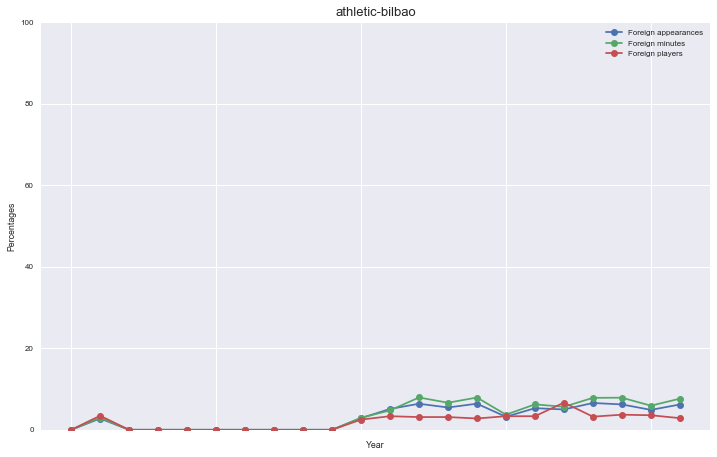

In [204]:
country = 'Spain'
team = 'athletic-bilbao'
df = get_team_percentages_df(country, team)
pprint(df)
plot_time_series(df, team, 100)

Athletic Bilbao (La Liga) exclusively sign players who were born in the  Basque Country, or who learned their football skills at a Basque club; as part of Basque nationalism. This makes it quite difficult for non Spanish players to be able to get recruited here. This explains the absurdly low percentage of foreign players in this team.

      Foreign appearances  Foreign minutes  Foreign players
Year                                                       
1995            18.965517        16.631397        25.000000
1996            28.510638        25.956600        35.294118
1997            34.497817        34.063383        37.500000
1998            41.452991        38.410715        36.363636
1999            41.594828        38.716695        43.333333
2000            43.487859        41.326713        40.000000
2001            52.991453        52.029675        43.750000
2002            47.751606        46.443365        43.750000
2003            52.277657        56.088241        51.428571
2004            49.658314        51.127238        50.000000
2005            46.799117        47.257158        40.000000
2006            55.097614        52.043004        43.750000
2007            64.102564        62.916257        50.000000
2008            68.000000        65.750297        63.157895
2009            57.082452        55.6235

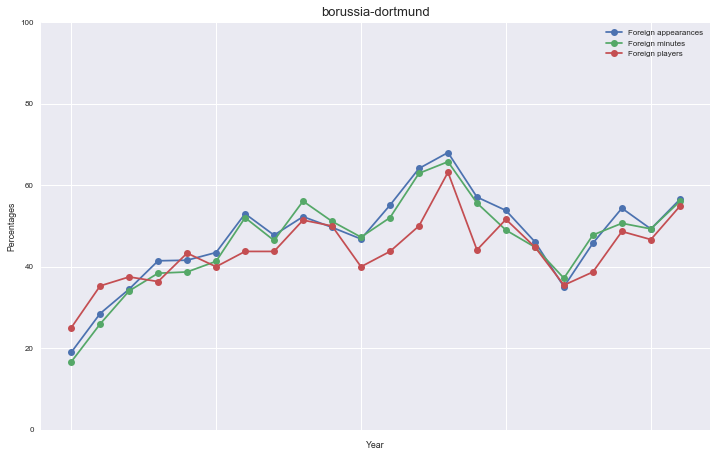

In [205]:
country = 'Germany'
team = 'borussia-dortmund'
df = get_team_percentages_df(country, team)
pprint(df)
plot_time_series(df, team, 100)

Borussia Dortmund (German Bundesliga) have an interesting history where they had a period of domination in the late 90's with 3 Bundesliga titles and a Champions League trophy. They went public (the only German club to have done so) in 2000. However, they faced financial troubles and in 2003, their rivals Bayern Munich loaned them 2 million euros for payroll purposes. 2005 was an even darker year where their stock price plummeted and they had to cut salaries. These financial troubles led to a massive dip in performance; finishing 13th (out of 18) in 2007-8.

Jürgen Klopp (he is German) was brought in as manager in May 2008 and proved to be the change that Dortmund needed. He changed their playing style and put more emphasis on proper utilization of academy/youth and domestic players. This also helped the team make more judicious use of their resources. The decline in percentage of foreign players and playing time given to foreign players from 2008-12 shows this phenomenon. Dortmund won two Bundesliga titles (2010-11 and 2011-12) and were the runners up in the 2012-13 Champions League (losing to domestic champions Bayern Munich) under Klopp's tutelage.

Dortmund are an excellent example of how proper utilization of local youth/talent can empower a team.

      Foreign appearances  Foreign minutes  Foreign players
Year                                                       
1995            24.890830        21.704146        26.666667
1996            24.637681        21.780506        31.250000
1997            45.129225        43.096379        43.333333
1998            53.984064        49.490873        52.777778
1999            66.011788        62.776193        57.142857
2000            67.330677        63.961203        66.666667
2001            62.840467        60.069547        55.555556
2002            68.511450        66.173367        67.741935
2003            79.724409        79.155785        71.875000
2004            88.514851        87.291450        87.500000
2005            93.604651        92.696166        84.848485
2006            96.887160        98.292741        85.714286
2007            94.961240        96.648179        87.500000
2008            93.762183        95.149124        78.947368
2009            91.809524        93.2474

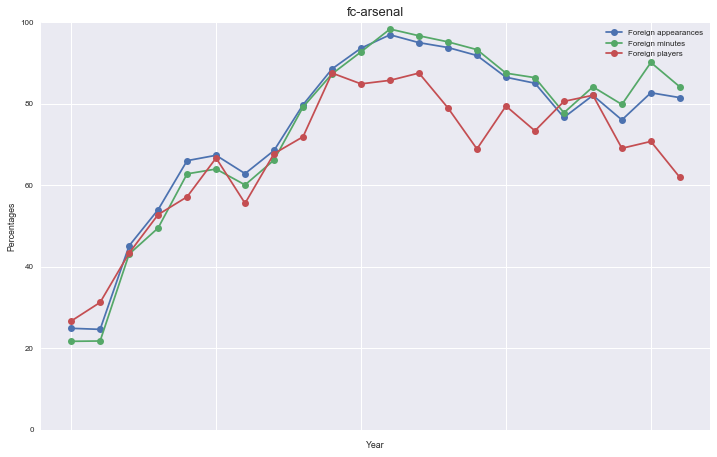

In [206]:
country = 'England'
team = 'fc-arsenal'
df = get_team_percentages_df(country, team)
pprint(df)
plot_time_series(df, team, 100)

Arsene Wenger (French) became Arsenal's manager in 1996 and brought about changes in players' diet (unheard of in those days) to maximize performance. Under Wenger's reign (he retired a few weeks ago), Arsenal attracted a lot of international talent, including highly talented Frenchmen like Vieira, Henry and Anelka.

In the 2003-4, Arsenal won the Premier League unbeaten (26 wins and 12 draws). As can be seen in the plot above, Arsenal has relied **heavily** on international players. In 2006, for instance, a whopping 98.3% of the total playing time was given to international players!
